# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

In [1]:
# Disable huggingface warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install seaborn
!pip install transformers
!pip install torcheval
!pip install gdown

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="images/human_values.png" alt="human values" />
</center>

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

In [3]:
!curl https://zenodo.org/records/8248658/files/arguments-training.tsv?download=1 -o arguments-training.tsv
!curl https://zenodo.org/records/8248658/files/arguments-validation.tsv?download=1 -o arguments-validation.tsv
!curl https://zenodo.org/records/8248658/files/arguments-test.tsv?download=1 -o arguments-test.tsv
!curl https://zenodo.org/records/8248658/files/labels-training.tsv?download=1 -o labels-training.tsv
!curl https://zenodo.org/records/8248658/files/labels-validation.tsv?download=1 -o labels-validation.tsv
!curl https://zenodo.org/records/8248658/files/labels-test.tsv?download=1 -o labels-test.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  988k  100  988k    0     0   137k      0  0:00:07  0:00:07 --:--:--  212k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  354k  100  354k    0     0   175k      0  0:00:02  0:00:02 --:--:--  175k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  283k  100  283k    0     0   179k      0  0:00:01  0:00:01 --:--:--  180k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  247k  100  247k    0     0   121k      0  0:00:02  0:00:02 --:--:--  121k
  % Total    % Received % Xferd  Average Speed   Tim

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

In [4]:
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torcheval.metrics.functional import binary_f1_score
from transformers import AutoTokenizer, AutoModel
import gdown

In [5]:
gdown.download('https://drive.usercontent.google.com/u/0/uc?id=17Nb2c918XvENe6JoP65cX95x27zXJT77&export=download', 'utils.tar.gz', quiet=False)

!tar -xf utils.tar.gz

Downloading...
From: https://drive.usercontent.google.com/u/0/uc?id=17Nb2c918XvENe6JoP65cX95x27zXJT77&export=download
To: /home/edo/PycharmProjects/NLP_projects/Assignment_2/utils.tar.gz
100%|██████████| 4.84k/4.84k [00:00<00:00, 384kB/s]


In [6]:
from file_reader import import_features, import_labels
from dataframe_modifier import modify_stance, create_third_level_labels
from CustomDataset import CustomDataset
from network_trainer import train, evaluate_model
from plots import generate_summary, generate_precision_recall_curve, generate_confusion_matrix, \
    generate_f1_scores_table, generate_bar_plot_with_f1_scores, generate_training_history_plots, \
    show_some_misclassified_examples, generate_bar_plot, generate_correlation_heatmap


save_best_models = True
# If `load_best_models` is set to True, the notebook will automatically try to download
# the models' weights from Google Drive
load_best_models = False
# TODO: update below link with the correct one
models_load_link = 'https://drive.usercontent.google.com/download?id=13xq53-QPIqb-SQAURvPL0v-YvzW6iPxh&export=download&confirm=t&uuid=75139e51-946d-4242-8a66-b50a58c05e5d'
models_load_path = 'best_models.tar'
models_save_path = 'best_models.tar'

plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_id = 1
models_dict = [{'name': 'bert-base-uncased', 'head_size': 768},
               {'name': 'roberta-base', 'head_size': 768},
               {'name': 'roberta-large', 'head_size': 1024}]

initializer_seed = 111
seeds = [16, 62, 845]

num_epochs = 10

In [7]:
random.seed(initializer_seed)
np.random.seed(initializer_seed)
torch.manual_seed(initializer_seed)

train_dataframe, validation_dataframe, test_dataframe = import_features()
lab_train_dataframe, lab_validation_dataframe, lab_test_dataframe = import_labels()
modify_stance(train_dataframe, validation_dataframe, test_dataframe)

third_level_train_dataframe, third_level_validation_dataframe, third_level_test_dataframe = \
    create_third_level_labels(lab_train_dataframe, lab_validation_dataframe, lab_test_dataframe)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(models_dict[model_id]['name'])

# Generate datasets and dataloaders
training_set = CustomDataset(train_dataframe, third_level_train_dataframe, tokenizer)
validation_set = CustomDataset(validation_dataframe, third_level_validation_dataframe, tokenizer)
test_set = CustomDataset(test_dataframe, third_level_test_dataframe, tokenizer)

training_loader = DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


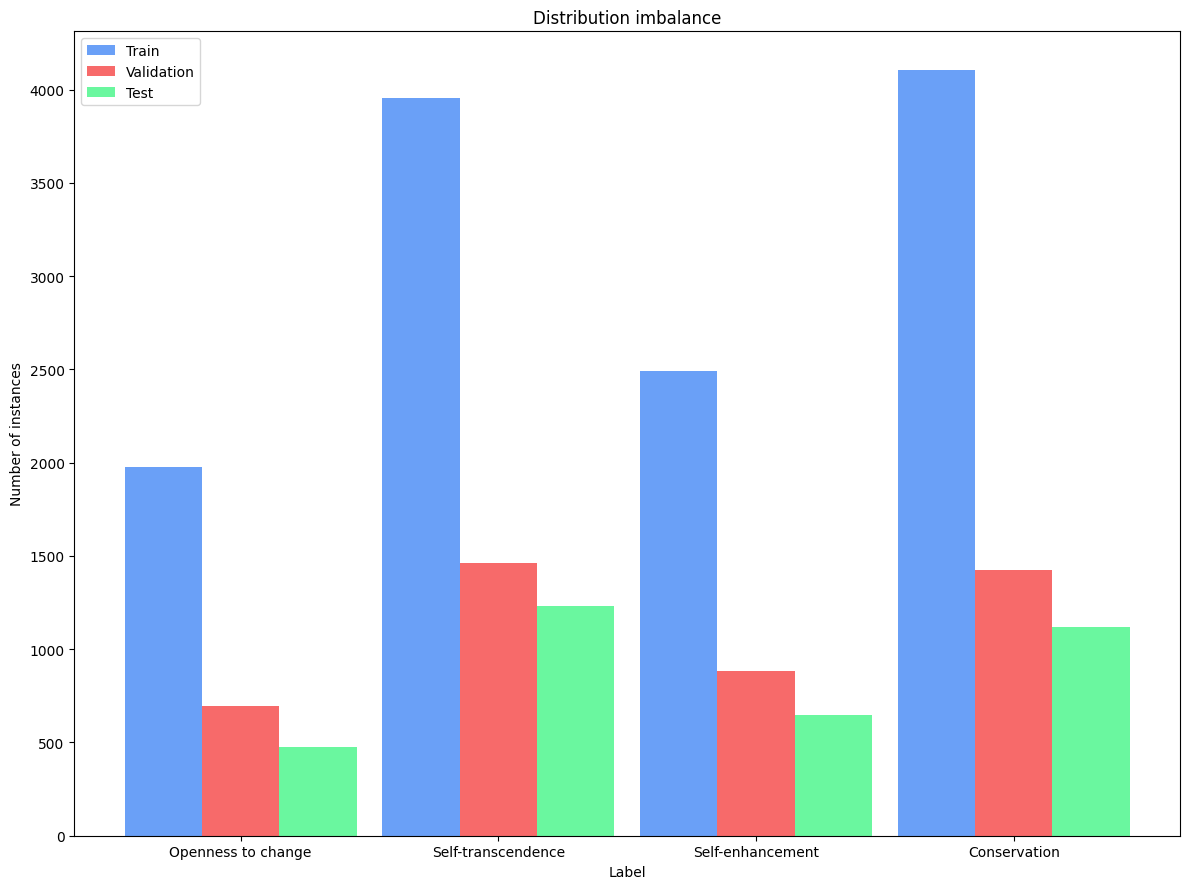

In [8]:
generate_bar_plot(third_level_train_dataframe, third_level_validation_dataframe, third_level_test_dataframe)

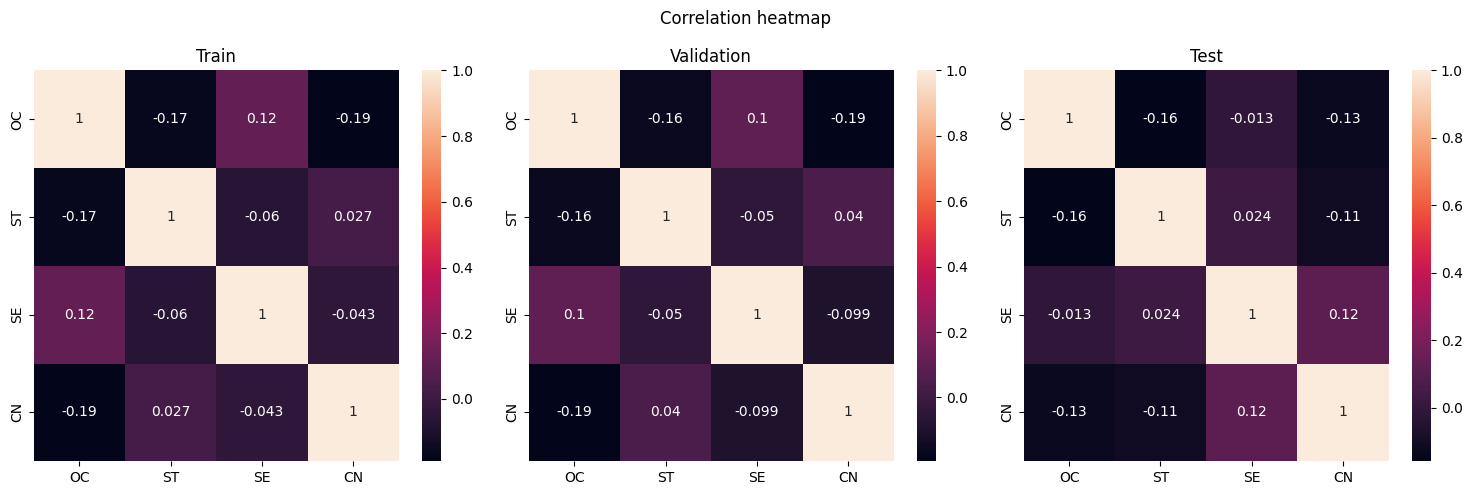

In [9]:
generate_correlation_heatmap(third_level_train_dataframe, third_level_validation_dataframe, third_level_test_dataframe)

# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="images/model_schema.png" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="images/bert_c.png" alt="BERT w/ C" />
</center>

### BERT w/ CP

<center>
    <img src="images/bert_cp.png" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="images/bert_cps.png" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="images/input_merging.png" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

In [10]:
def random_uniform_classifier(test_labels):
    test_labels = test_labels.values
    n_instances = test_labels.shape[0]
    n_classes = test_labels.shape[1]

    predictions = np.random.randint(2, size=(n_instances, n_classes))
    predictions = torch.Tensor(predictions)
    return predictions


def majority_classifier(training_labels, test_labels):
    training_labels = training_labels.values
    test_labels = test_labels.values
    n_instances = test_labels.shape[0]
    n_classes = test_labels.shape[1]

    predictions = np.zeros((n_instances, n_classes))
    for i in range(n_classes):
        if np.sum(training_labels[:, i]) >= len(training_labels) / 2:
            predictions[:, i] = 1
    predictions = torch.Tensor(predictions)
    return predictions


def one_baseline(test_labels):
    test_labels = test_labels.values
    n_instances = test_labels.shape[0]
    n_classes = test_labels.shape[1]

    predictions = np.ones((n_instances, n_classes))
    predictions = torch.Tensor(predictions)
    return predictions


# Baselines
# 1. Random
predictions_random = random_uniform_classifier(third_level_test_dataframe)
val_predictions_random = random_uniform_classifier(third_level_validation_dataframe)

# 2. Majority
predictions_majority = majority_classifier(third_level_train_dataframe, third_level_test_dataframe)
val_predictions_majority = majority_classifier(third_level_train_dataframe, third_level_validation_dataframe)

# 3. 1-baseline
predictions_one = one_baseline(third_level_test_dataframe)
val_predictions_one = one_baseline(third_level_validation_dataframe)

In [11]:
class ClassifierC(nn.Module):
    def __init__(self, name, head_size):
        super(ClassifierC, self).__init__()
        self.name_ = 'C'
        self.embedder = AutoModel.from_pretrained(name)
        for param in self.embedder.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(head_size, 4)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x[0]
        attention_mask = x['attention_mask'].unsqueeze(-1)
        x = self.embedder(**x).last_hidden_state
        x = x * attention_mask
        x = x.mean(dim=1)
        x = self.linear(x)
        x = (self.tanh(x) + 1) / 2
        return x


class ClassifierCP(nn.Module):
    def __init__(self, name, head_size):
        super(ClassifierCP, self).__init__()
        self.name_ = 'CP'
        self.embedder = AutoModel.from_pretrained(name)
        for param in self.embedder.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(head_size * 2, 4)
        self.tanh = nn.Tanh()

    def forward(self, x):
        y = x[0]
        z = x[1]
        attention_mask_y = y['attention_mask'].unsqueeze(-1)
        attention_mask_z = z['attention_mask'].unsqueeze(-1)
        y = self.embedder(**y).last_hidden_state
        z = self.embedder(**z).last_hidden_state
        y = y * attention_mask_y
        z = z * attention_mask_z
        y = y.mean(dim=1)
        z = z.mean(dim=1)
        x = torch.cat([y, z], 1)
        x = self.linear(x)
        x = (self.tanh(x) + 1) / 2
        return x


class ClassifierCPS(nn.Module):
    def __init__(self, name, head_size):
        super(ClassifierCPS, self).__init__()
        self.name_ = 'CPS'
        self.embedder = AutoModel.from_pretrained(name)
        for param in self.embedder.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(head_size * 2 + 1, 4)
        self.tanh = nn.Tanh()

    def forward(self, x):
        y = x[0]
        z = x[1]
        w = x[2]
        attention_mask_y = y['attention_mask'].unsqueeze(-1)
        attention_mask_z = z['attention_mask'].unsqueeze(-1)
        y = self.embedder(**y).last_hidden_state
        z = self.embedder(**z).last_hidden_state
        y = y * attention_mask_y
        z = z * attention_mask_z
        y = y.mean(dim=1)
        z = z.mean(dim=1)
        x = torch.cat([y, z, w.reshape((y.shape[0], 1))], 1)
        x = self.linear(x)
        x = (self.tanh(x) + 1) / 2
        return x

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conversation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conversation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

In [12]:
def calculate_f1_score(predictions, targets, verbose=False):
    cols = predictions.shape[1]
    single_class_scores = torch.zeros(cols)
    for i in range(cols):
        single_class_scores[i] = binary_f1_score(predictions[:, i], targets[:, i])
        if verbose:
            print('F1 score for column %d: %.3f' % (i, single_class_scores[i]))
    return torch.mean(single_class_scores), single_class_scores

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

In [13]:
# Initialize training data structures
histories = {}
best_models = {}
models = {'C': ClassifierC,
          'CP': ClassifierCP,
          'CPS': ClassifierCPS
          }

# Train models
if not load_best_models:
    for seed in seeds:
        for model_type, model_class in models.items():
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            print('Set seed to: ', seed)

            model = model_class(**models_dict[model_id])
            model_trained, history = train(model, training_loader, validation_loader, num_epochs)
            if model_type not in histories:
                histories[model_type] = history
                best_models[model_type] = model_trained
            else:
                if history['best_val_macro_f1'] > histories[model_type]['best_val_macro_f1']:
                    histories[model_type] = history
                    best_models[model_type] = model_trained

    if save_best_models:
        torch.save({
            'modelC_state_dict': best_models['C'].state_dict(),
            'modelCP_state_dict': best_models['CP'].state_dict(),
            'modelCPS_state_dict': best_models['CPS'].state_dict(),
            'historyC': histories['C'],
            'historyCP': histories['CP'],
            'historyCPS': histories['CPS']
        }, models_save_path)
        print('Models saved successfully to: ', models_save_path, '\n')
else:
    # TODO: uncomment line below if you want to download the models' weights
    #gdown.download(models_load_link, models_load_path, quiet=False)

    checkpoint = torch.load(models_load_path, map_location=device)
    best_models['C'] = ClassifierC(**models_dict[model_id])
    best_models['C'].load_state_dict(checkpoint['modelC_state_dict'])
    best_models['CP'] = ClassifierCP(**models_dict[model_id])
    best_models['CP'].load_state_dict(checkpoint['modelCP_state_dict'])
    best_models['CPS'] = ClassifierCPS(**models_dict[model_id])
    best_models['CPS'].load_state_dict(checkpoint['modelCPS_state_dict'])
    histories['C'] = checkpoint['historyC']
    histories['CP'] = checkpoint['historyCP']
    histories['CPS'] = checkpoint['historyCPS']
    print('Models loaded successfully from: ', models_load_path, '\n')

Set seed to:  16


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model C:
[1,  10] loss: 0.619
[1,  20] loss: 0.612
[1,  30] loss: 0.653
[1,  40] loss: 0.628
[1,  50] loss: 0.573
[1,  60] loss: 0.628
[1,  70] loss: 0.606
[1,  80] loss: 0.620
[1,  90] loss: 0.596
[1, 100] loss: 0.615
[1, 110] loss: 0.597
[1, 120] loss: 0.598
[1, 130] loss: 0.618
[1, 140] loss: 0.626
[1, 150] loss: 0.619
[1, 160] loss: 0.589
[1, 170] loss: 0.575
[1, 180] loss: 0.586
[1, 190] loss: 0.615
[1, 200] loss: 0.590
[1, 210] loss: 0.595
[1, 220] loss: 0.614
[1, 230] loss: 0.602
[1, 240] loss: 0.586
[1, 250] loss: 0.596
[1, 260] loss: 0.594
[1, 270] loss: 0.575
[1, 280] loss: 0.594
[1, 290] loss: 0.559
[1, 300] loss: 0.608
[1, 310] loss: 0.570
[1, 320] loss: 0.572
[1, 330] loss: 0.588
Evaluating the model on the validation set...
Loss: 0.633
Macro F1 score: 0.631 - Class F1 score: [0.203 0.871 0.591 0.858]
New best model found! Saving it...
Epoch 2/10 on model C:
[2,  10] loss: 0.569
[2,  20] loss: 0.602
[2,  30] loss: 0.

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CP:
[1,  10] loss: 0.632
[1,  20] loss: 0.625
[1,  30] loss: 0.585
[1,  40] loss: 0.565
[1,  50] loss: 0.569
[1,  60] loss: 0.612
[1,  70] loss: 0.579
[1,  80] loss: 0.577
[1,  90] loss: 0.580
[1, 100] loss: 0.561
[1, 110] loss: 0.595
[1, 120] loss: 0.554
[1, 130] loss: 0.567
[1, 140] loss: 0.551
[1, 150] loss: 0.589
[1, 160] loss: 0.542
[1, 170] loss: 0.529
[1, 180] loss: 0.536
[1, 190] loss: 0.523
[1, 200] loss: 0.565
[1, 210] loss: 0.541
[1, 220] loss: 0.561
[1, 230] loss: 0.552
[1, 240] loss: 0.549
[1, 250] loss: 0.567
[1, 260] loss: 0.535
[1, 270] loss: 0.588
[1, 280] loss: 0.560
[1, 290] loss: 0.563
[1, 300] loss: 0.517
[1, 310] loss: 0.592
[1, 320] loss: 0.550
[1, 330] loss: 0.525
Evaluating the model on the validation set...
Loss: 0.565
Macro F1 score: 0.683 - Class F1 score: [0.371 0.871 0.632 0.859]
New best model found! Saving it...
Epoch 2/10 on model CP:
[2,  10] loss: 0.499
[2,  20] loss: 0.571
[2,  30] loss: 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loss: 0.562
Macro F1 score: 0.717 - Class F1 score: [0.567 0.849 0.589 0.862]
Finished Training

Set seed to:  16
The model will be running on cuda:0 device
Epoch 1/10 on model CPS:
[1,  10] loss: 0.640
[1,  20] loss: 0.604
[1,  30] loss: 0.604
[1,  40] loss: 0.621
[1,  50] loss: 0.588
[1,  60] loss: 0.558
[1,  70] loss: 0.565
[1,  80] loss: 0.565
[1,  90] loss: 0.562
[1, 100] loss: 0.575
[1, 110] loss: 0.526
[1, 120] loss: 0.557
[1, 130] loss: 0.530
[1, 140] loss: 0.556
[1, 150] loss: 0.568
[1, 160] loss: 0.564
[1, 170] loss: 0.588
[1, 180] loss: 0.560
[1, 190] loss: 0.545
[1, 200] loss: 0.578
[1, 210] loss: 0.559
[1, 220] loss: 0.561
[1, 230] loss: 0.570
[1, 240] loss: 0.561
[1, 250] loss: 0.507
[1, 260] loss: 0.554
[1, 270] loss: 0.563
[1, 280] loss: 0.544
[1, 290] loss: 0.538
[1, 300] loss: 0.552
[1, 310] loss: 0.566
[1, 320] loss: 0.549
[1, 330] loss: 0.523
Evaluating the model on the validation set...
Loss: 0.563
Macro F1 score: 0.681 - Class F1 score: [0.436 0.867 0.561 0.859]
N

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model C:
[1,  10] loss: 0.651
[1,  20] loss: 0.622
[1,  30] loss: 0.630
[1,  40] loss: 0.620
[1,  50] loss: 0.625
[1,  60] loss: 0.632
[1,  70] loss: 0.629
[1,  80] loss: 0.611
[1,  90] loss: 0.586
[1, 100] loss: 0.591
[1, 110] loss: 0.616
[1, 120] loss: 0.614
[1, 130] loss: 0.587
[1, 140] loss: 0.579
[1, 150] loss: 0.604
[1, 160] loss: 0.589
[1, 170] loss: 0.607
[1, 180] loss: 0.557
[1, 190] loss: 0.594
[1, 200] loss: 0.572
[1, 210] loss: 0.604
[1, 220] loss: 0.606
[1, 230] loss: 0.609
[1, 240] loss: 0.608
[1, 250] loss: 0.575
[1, 260] loss: 0.597
[1, 270] loss: 0.609
[1, 280] loss: 0.562
[1, 290] loss: 0.585
[1, 300] loss: 0.602
[1, 310] loss: 0.559
[1, 320] loss: 0.567
[1, 330] loss: 0.570
Evaluating the model on the validation set...
Loss: 0.639
Macro F1 score: 0.600 - Class F1 score: [0.173 0.871 0.498 0.859]
New best model found! Saving it...
Epoch 2/10 on model C:
[2,  10] loss: 0.596
[2,  20] loss: 0.566
[2,  30] loss: 0.

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CP:
[1,  10] loss: 0.636
[1,  20] loss: 0.577
[1,  30] loss: 0.633
[1,  40] loss: 0.598
[1,  50] loss: 0.561
[1,  60] loss: 0.628
[1,  70] loss: 0.588
[1,  80] loss: 0.584
[1,  90] loss: 0.609
[1, 100] loss: 0.581
[1, 110] loss: 0.524
[1, 120] loss: 0.597
[1, 130] loss: 0.575
[1, 140] loss: 0.546
[1, 150] loss: 0.579
[1, 160] loss: 0.561
[1, 170] loss: 0.570
[1, 180] loss: 0.536
[1, 190] loss: 0.537
[1, 200] loss: 0.550
[1, 210] loss: 0.550
[1, 220] loss: 0.543
[1, 230] loss: 0.545
[1, 240] loss: 0.576
[1, 250] loss: 0.499
[1, 260] loss: 0.544
[1, 270] loss: 0.579
[1, 280] loss: 0.531
[1, 290] loss: 0.541
[1, 300] loss: 0.545
[1, 310] loss: 0.527
[1, 320] loss: 0.529
[1, 330] loss: 0.528
Evaluating the model on the validation set...
Loss: 0.565
Macro F1 score: 0.699 - Class F1 score: [0.446 0.866 0.624 0.86 ]
New best model found! Saving it...
Epoch 2/10 on model CP:
[2,  10] loss: 0.503
[2,  20] loss: 0.542
[2,  30] loss: 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loss: 0.560
Macro F1 score: 0.716 - Class F1 score: [0.543 0.852 0.608 0.861]
Finished Training

Set seed to:  62
The model will be running on cuda:0 device
Epoch 1/10 on model CPS:
[1,  10] loss: 0.633
[1,  20] loss: 0.600
[1,  30] loss: 0.632
[1,  40] loss: 0.571
[1,  50] loss: 0.569
[1,  60] loss: 0.587
[1,  70] loss: 0.569
[1,  80] loss: 0.569
[1,  90] loss: 0.557
[1, 100] loss: 0.576
[1, 110] loss: 0.553
[1, 120] loss: 0.569
[1, 130] loss: 0.556
[1, 140] loss: 0.605
[1, 150] loss: 0.585
[1, 160] loss: 0.580
[1, 170] loss: 0.521
[1, 180] loss: 0.537
[1, 190] loss: 0.577
[1, 200] loss: 0.548
[1, 210] loss: 0.549
[1, 220] loss: 0.551
[1, 230] loss: 0.558
[1, 240] loss: 0.528
[1, 250] loss: 0.574
[1, 260] loss: 0.556
[1, 270] loss: 0.525
[1, 280] loss: 0.527
[1, 290] loss: 0.540
[1, 300] loss: 0.520
[1, 310] loss: 0.555
[1, 320] loss: 0.552
[1, 330] loss: 0.534
Evaluating the model on the validation set...
Loss: 0.593
Macro F1 score: 0.680 - Class F1 score: [0.327 0.867 0.663 0.862]
N

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loss: 0.569
Macro F1 score: 0.713 - Class F1 score: [0.535 0.856 0.601 0.86 ]
Finished Training

Set seed to:  845
The model will be running on cuda:0 device
Epoch 1/10 on model C:
[1,  10] loss: 0.638
[1,  20] loss: 0.613
[1,  30] loss: 0.613
[1,  40] loss: 0.602
[1,  50] loss: 0.593
[1,  60] loss: 0.593
[1,  70] loss: 0.619
[1,  80] loss: 0.609
[1,  90] loss: 0.607
[1, 100] loss: 0.605
[1, 110] loss: 0.611
[1, 120] loss: 0.582
[1, 130] loss: 0.618
[1, 140] loss: 0.605
[1, 150] loss: 0.613
[1, 160] loss: 0.586
[1, 170] loss: 0.614
[1, 180] loss: 0.613
[1, 190] loss: 0.593
[1, 200] loss: 0.579
[1, 210] loss: 0.577
[1, 220] loss: 0.577
[1, 230] loss: 0.580
[1, 240] loss: 0.589
[1, 250] loss: 0.580
[1, 260] loss: 0.596
[1, 270] loss: 0.614
[1, 280] loss: 0.578
[1, 290] loss: 0.593
[1, 300] loss: 0.614
[1, 310] loss: 0.543
[1, 320] loss: 0.589
[1, 330] loss: 0.572
Evaluating the model on the validation set...
Loss: 0.625
Macro F1 score: 0.590 - Class F1 score: [0.095 0.868 0.536 0.859]
Ne

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CP:
[1,  10] loss: 0.632
[1,  20] loss: 0.654
[1,  30] loss: 0.611
[1,  40] loss: 0.638
[1,  50] loss: 0.584
[1,  60] loss: 0.587
[1,  70] loss: 0.590
[1,  80] loss: 0.582
[1,  90] loss: 0.581
[1, 100] loss: 0.567
[1, 110] loss: 0.546
[1, 120] loss: 0.575
[1, 130] loss: 0.550
[1, 140] loss: 0.558
[1, 150] loss: 0.571
[1, 160] loss: 0.549
[1, 170] loss: 0.531
[1, 180] loss: 0.555
[1, 190] loss: 0.528
[1, 200] loss: 0.550
[1, 210] loss: 0.523
[1, 220] loss: 0.557
[1, 230] loss: 0.561
[1, 240] loss: 0.565
[1, 250] loss: 0.546
[1, 260] loss: 0.512
[1, 270] loss: 0.548
[1, 280] loss: 0.531
[1, 290] loss: 0.575
[1, 300] loss: 0.559
[1, 310] loss: 0.535
[1, 320] loss: 0.523
[1, 330] loss: 0.532
Evaluating the model on the validation set...
Loss: 0.584
Macro F1 score: 0.659 - Class F1 score: [0.481 0.864 0.438 0.854]
New best model found! Saving it...
Epoch 2/10 on model CP:
[2,  10] loss: 0.508
[2,  20] loss: 0.530
[2,  30] loss: 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CPS:
[1,  10] loss: 0.646
[1,  20] loss: 0.616
[1,  30] loss: 0.644
[1,  40] loss: 0.593
[1,  50] loss: 0.586
[1,  60] loss: 0.584
[1,  70] loss: 0.619
[1,  80] loss: 0.574
[1,  90] loss: 0.569
[1, 100] loss: 0.594
[1, 110] loss: 0.583
[1, 120] loss: 0.588
[1, 130] loss: 0.561
[1, 140] loss: 0.567
[1, 150] loss: 0.582
[1, 160] loss: 0.564
[1, 170] loss: 0.538
[1, 180] loss: 0.532
[1, 190] loss: 0.569
[1, 200] loss: 0.555
[1, 210] loss: 0.568
[1, 220] loss: 0.512
[1, 230] loss: 0.540
[1, 240] loss: 0.569
[1, 250] loss: 0.551
[1, 260] loss: 0.528
[1, 270] loss: 0.550
[1, 280] loss: 0.522
[1, 290] loss: 0.514
[1, 300] loss: 0.514
[1, 310] loss: 0.511
[1, 320] loss: 0.537
[1, 330] loss: 0.552
Evaluating the model on the validation set...
Loss: 0.590
Macro F1 score: 0.620 - Class F1 score: [0.15  0.868 0.604 0.859]
New best model found! Saving it...
Epoch 2/10 on model CPS:
[2,  10] loss: 0.531
[2,  20] loss: 0.513
[2,  30] loss

## Validation Macro F1 scores

In [14]:
val_macro_f1_scores = []
# Baselines over validation set
val_macro_f1_scores.append(
    ['random', calculate_f1_score(val_predictions_random, torch.Tensor(third_level_validation_dataframe.values))[0].item()])
val_macro_f1_scores.append(
    ['majority', calculate_f1_score(val_predictions_majority, torch.Tensor(third_level_validation_dataframe.values))[0].item()])
val_macro_f1_scores.append(
    ['one', calculate_f1_score(val_predictions_one, torch.Tensor(third_level_validation_dataframe.values))[0].item()])

for model_type, history in histories.items():
    val_macro_f1_scores.append([model_type, history['best_val_macro_f1']])

val_macro_f1_scores = pd.DataFrame(val_macro_f1_scores, columns=['Model', 'Macro F1 score'])
val_macro_f1_scores

,Model,Macro F1 score
0,random,0.533386
1,majority,0.432403
2,one,0.726060
3,C,0.678554
4,CP,0.732701
5,CPS,0.736183


## Evaluation of best models on test set

In [15]:
outputs_dict = {'random': predictions_random, 'majority': predictions_majority, 'one': predictions_one}
labels = third_level_test_dataframe.values
crisp_predictions_dict = copy.deepcopy(outputs_dict)

summaries = []
for model_type, model in best_models.items():
    _, _, _, outputs, labels_, crisp_predictions = evaluate_model(model, test_loader, device, verbose=False)
    assert np.array_equal(labels, labels_)
    outputs_dict[model_type] = outputs
    crisp_predictions_dict[model_type] = crisp_predictions

    summaries.append(generate_summary(crisp_predictions, labels, verbose=False))

## Test Macro F1 scores - Classifier C

In [16]:
summaries[0]

,Precision,Recall,F1
Openness to change,0.342495,0.341772,0.342133
Self-transcendence,0.781091,1.000000,0.877093
Self-enhancement,0.457270,0.636785,0.532300
Conservation,0.712508,0.972297,0.822373


## Test Macro F1 scores - Classifier CP

In [17]:
summaries[1]

,Precision,Recall,F1
Openness to change,0.585746,0.554852,0.569881
Self-transcendence,0.802667,0.978067,0.881728
Self-enhancement,0.596369,0.659969,0.626559
Conservation,0.736916,0.943700,0.827586


## Test Macro F1 scores - Classifier CPS

In [18]:
summaries[2]

,Precision,Recall,F1
Openness to change,0.594203,0.518987,0.554054
Self-transcendence,0.804201,0.964257,0.876986
Self-enhancement,0.593794,0.650696,0.620944
Conservation,0.709657,0.998213,0.829558


## Yet another F1 score table

In [19]:
f1_score_table = generate_f1_scores_table(outputs_dict, labels, crisp_predictions_dict, verbose=False)
f1_score_table

,Model,Macro F1 score,Openness to change,Self-transcendence,Self-enhancement,Conservation
0,random,0.505339,0.368127,0.600297,0.463027,0.589905
1,majority,0.426880,0.000000,0.877093,0.000000,0.830427
2,one,0.688014,0.462439,0.877093,0.582096,0.830427
3,C,0.643475,0.342133,0.877093,0.532300,0.822373
4,CP,0.726439,0.569881,0.881728,0.626559,0.827586
5,CPS,0.720385,0.554054,0.876986,0.620944,0.829558


# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

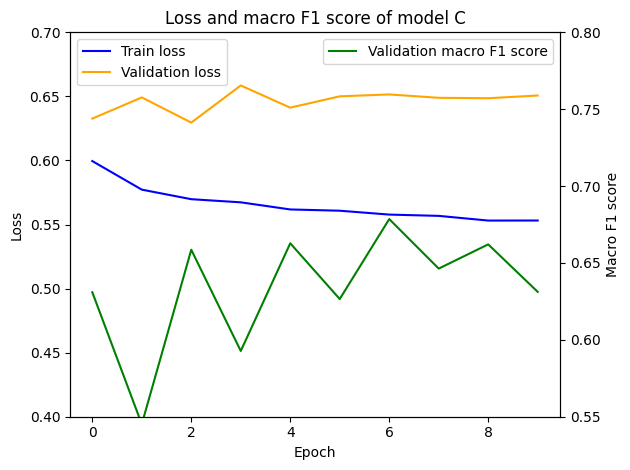

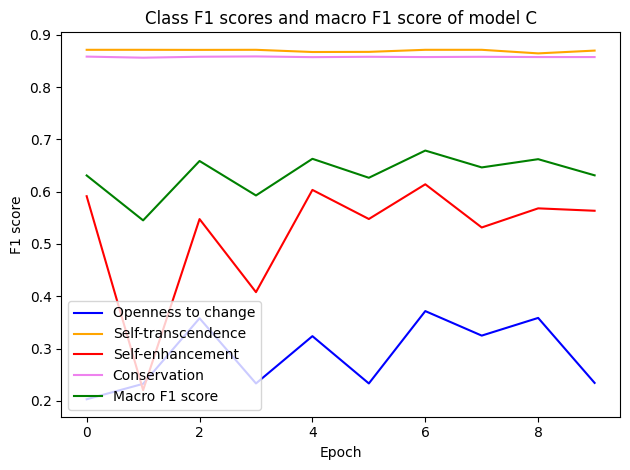

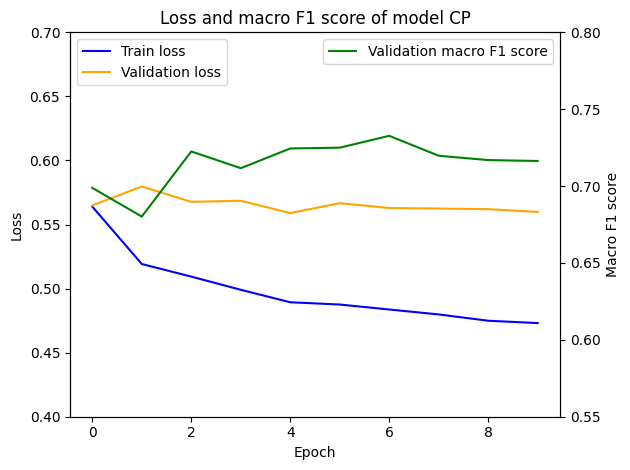

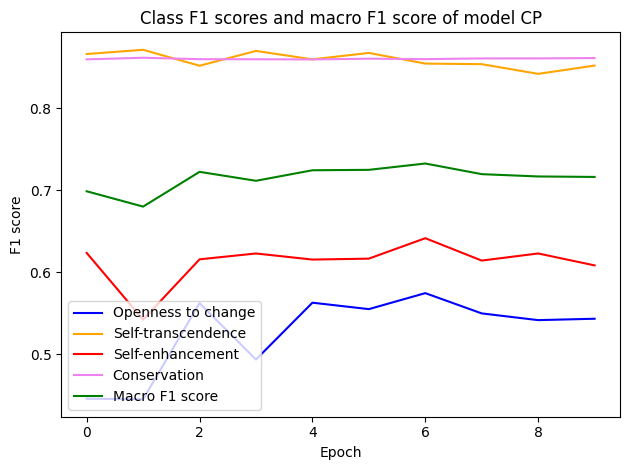

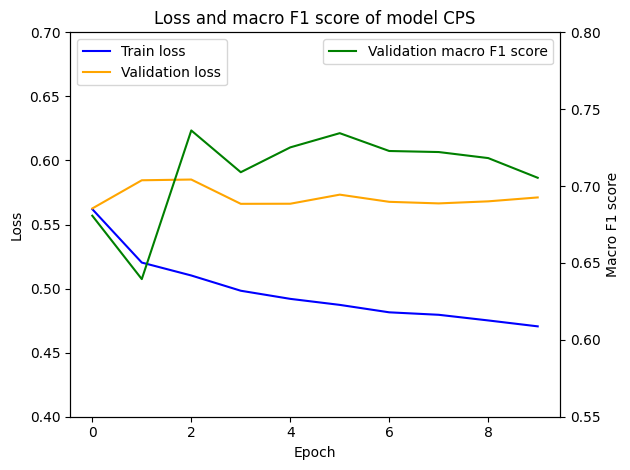

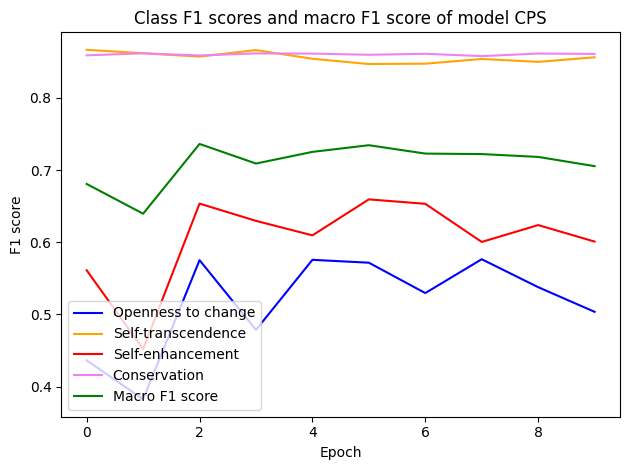

In [20]:
generate_training_history_plots(histories)

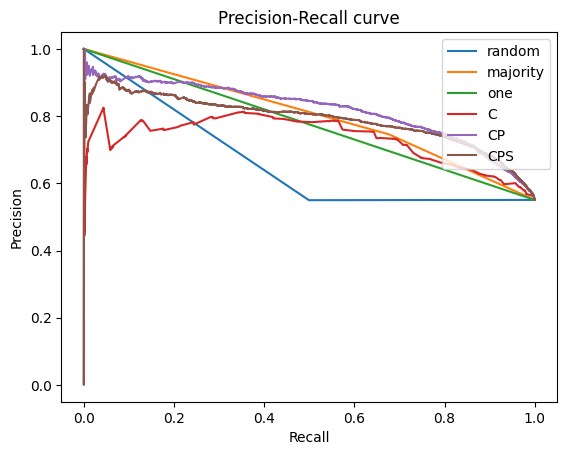

In [21]:
generate_precision_recall_curve(outputs_dict, labels, crisp_predictions_dict)

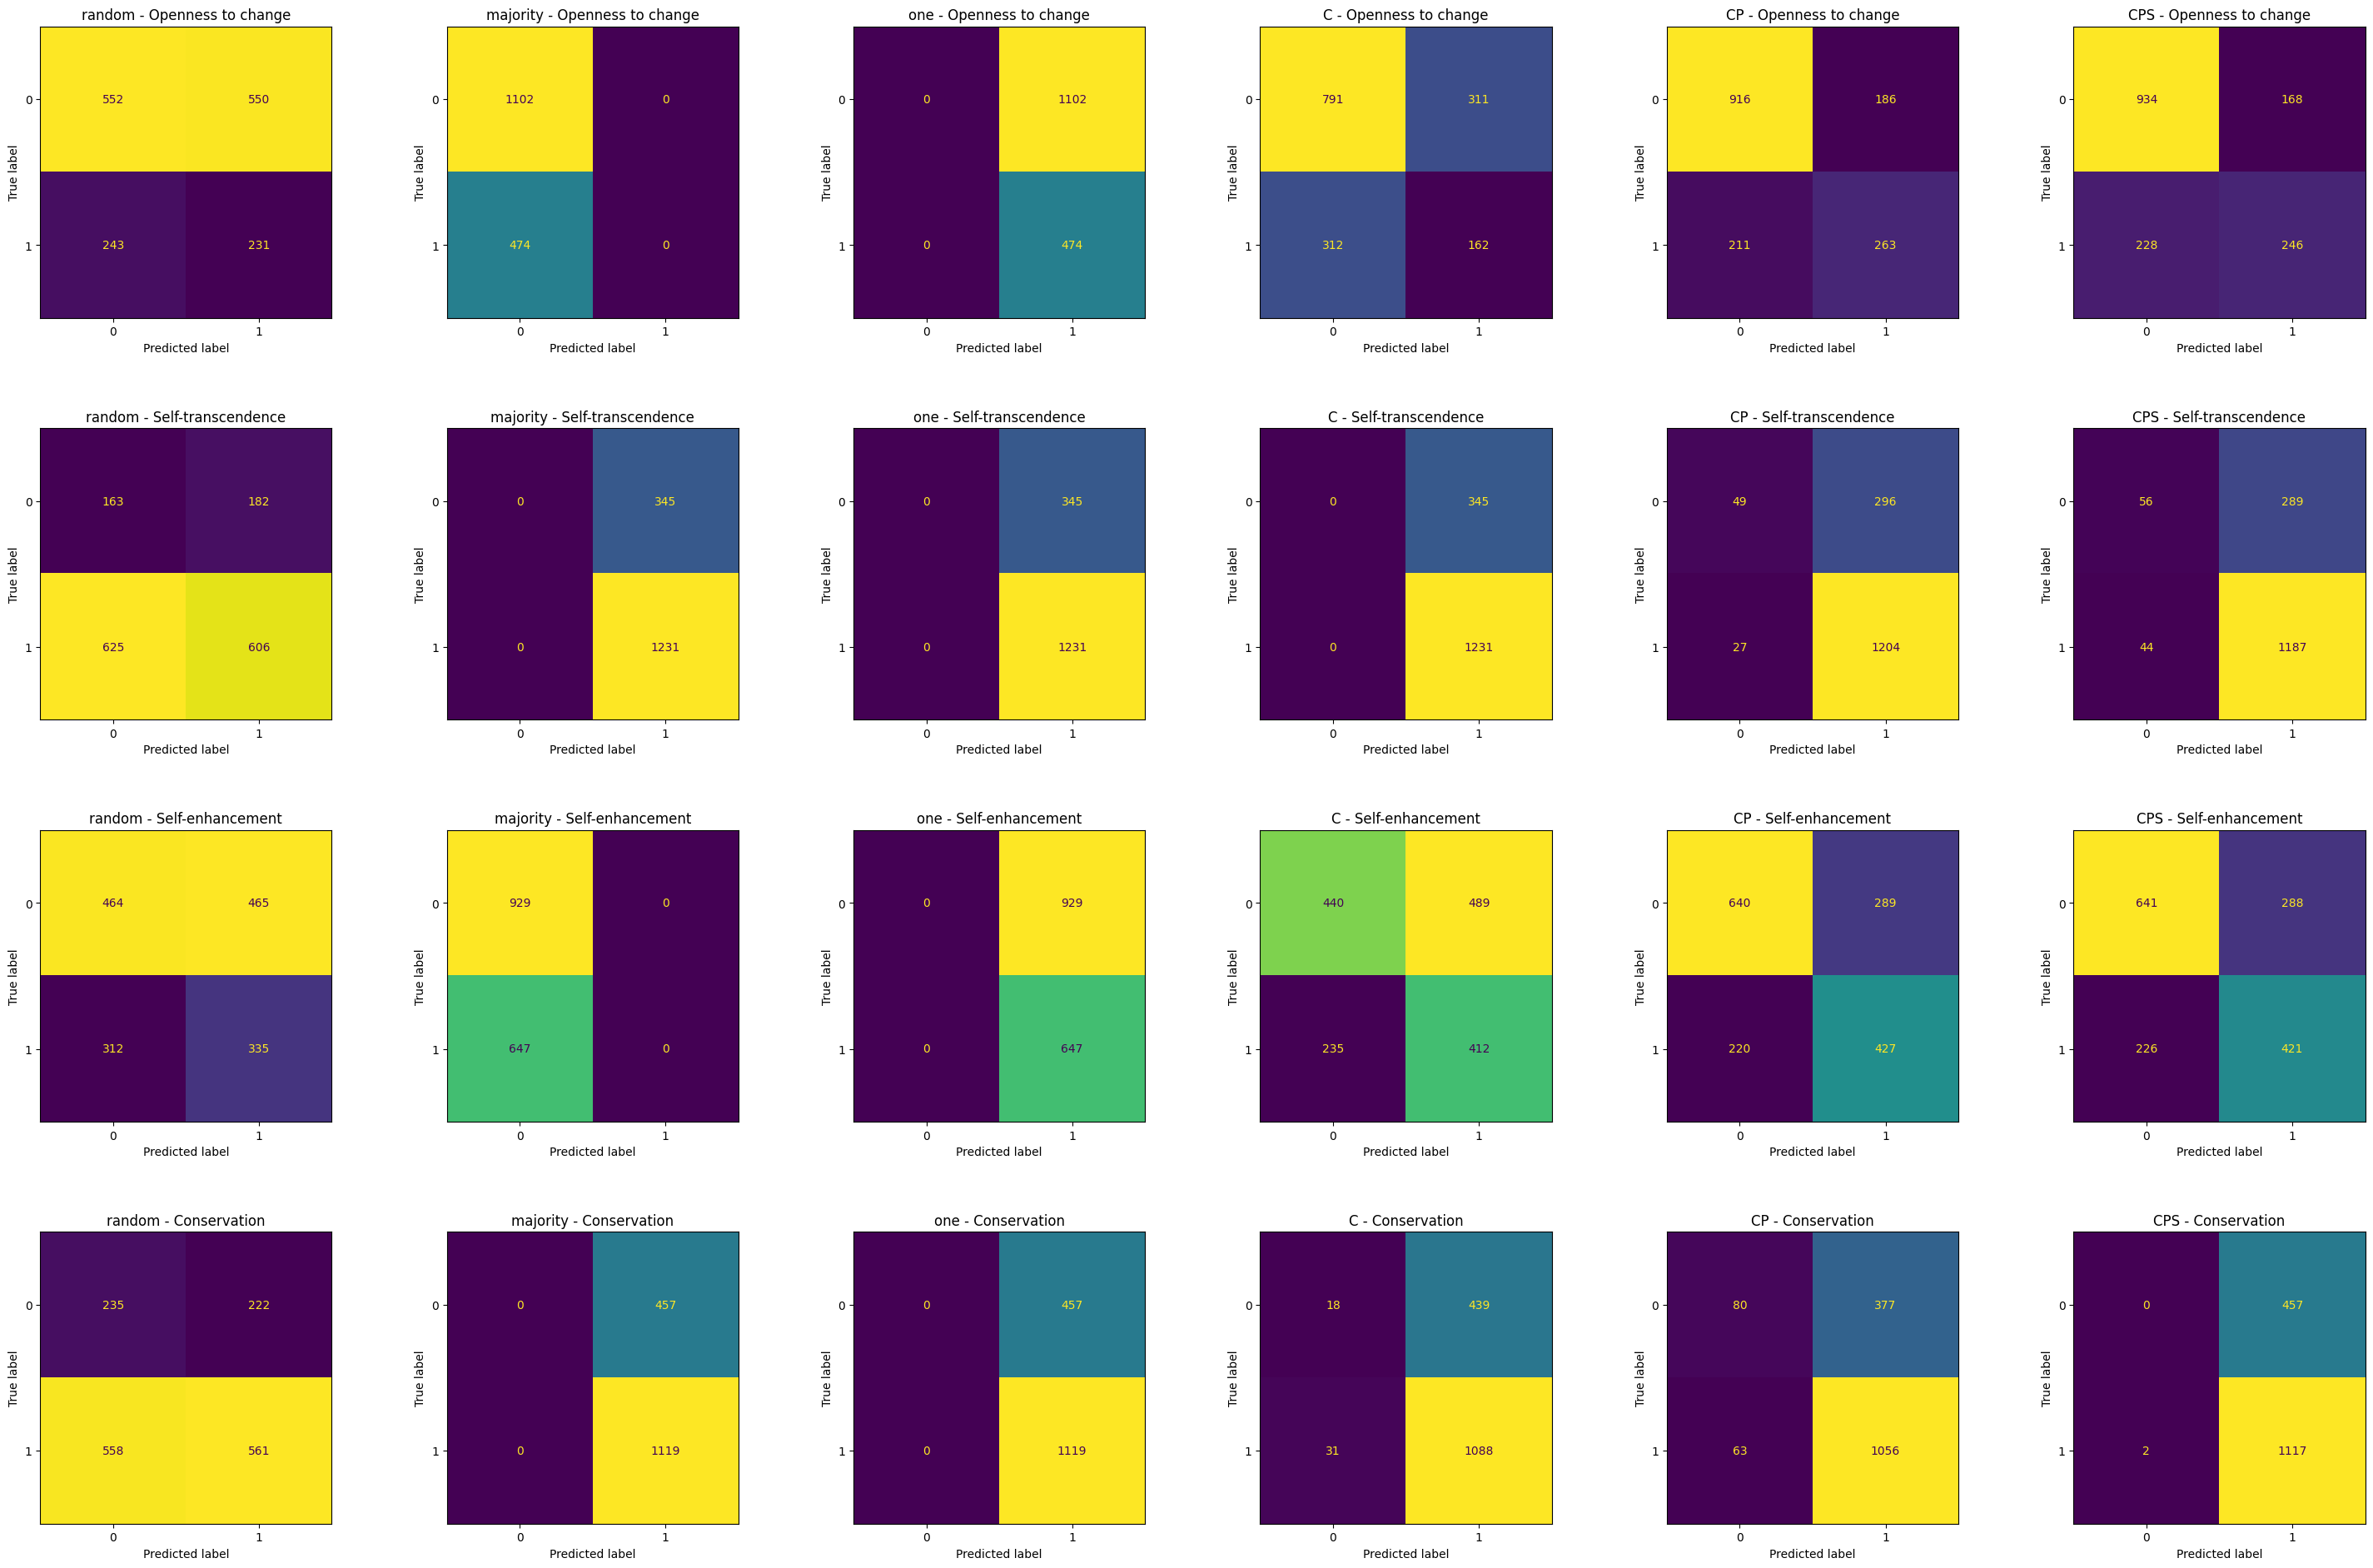

In [22]:
generate_confusion_matrix(outputs_dict, labels, crisp_predictions_dict)

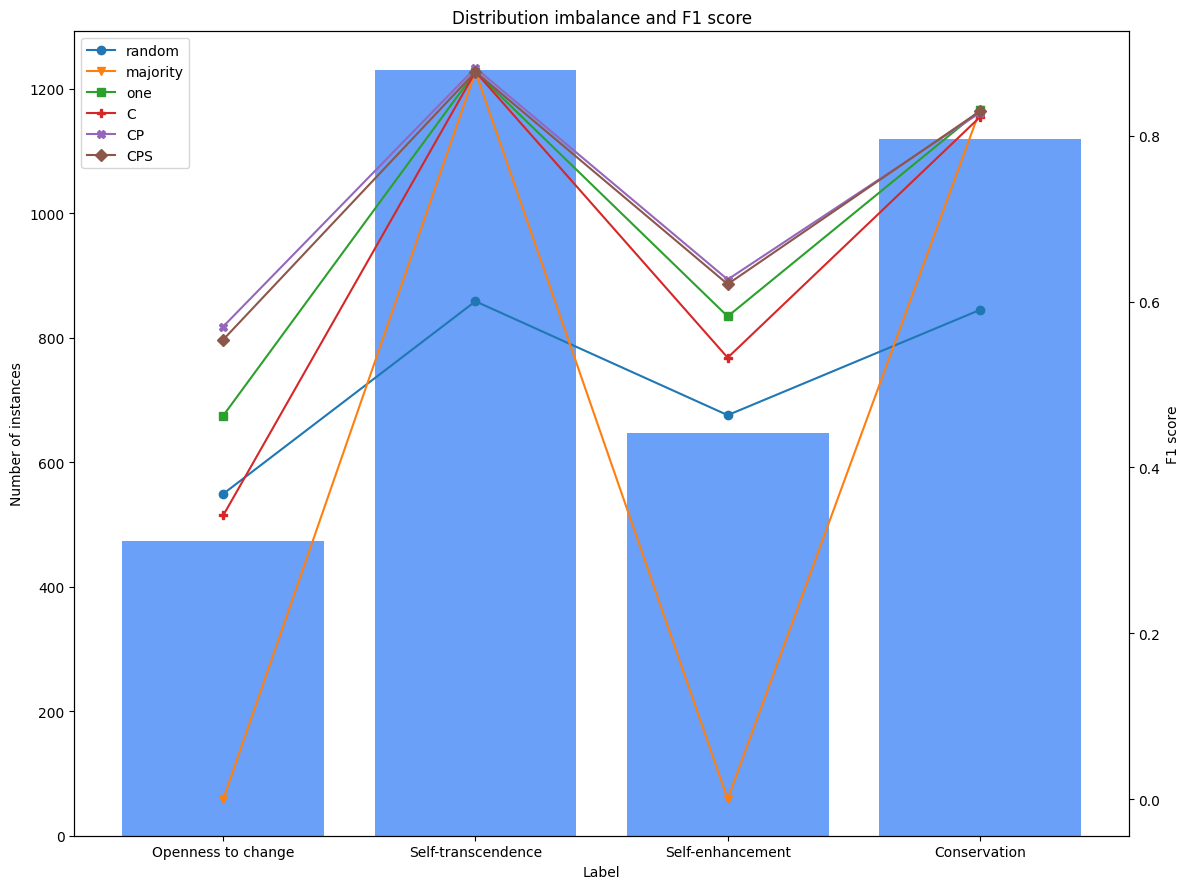

In [23]:
generate_bar_plot_with_f1_scores(outputs_dict, labels, crisp_predictions_dict)

In [24]:
misclassified_dict = show_some_misclassified_examples(test_dataframe, labels, crisp_predictions_dict, verbose=False)

## Misclassified examples - Classifier C - Label: Openness to change

In [25]:
misclassified_dict['C'][0]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should fight urbanization,0,urbanization is the most efficient manner of s...,0.0,1.0,1.0,1.0
1,We should legalize polygamy,1,some of the country already legalized polygamy...,0.0,1.0,0.0,1.0
2,We should end affirmative action,0,affirmative action allows people to pursue a c...,0.0,1.0,1.0,1.0
3,We should further develop the European integra...,1,"Less centralization in Brussels, more flexibil...",0.0,1.0,1.0,1.0
4,We should create a common constitution,0,"The EU is not a country, but a free associatio...",0.0,1.0,1.0,1.0
5,We should prohibit flag burning,0,prohibiting flag burning threatens freedom of ...,0.0,1.0,0.0,1.0
6,We should prohibit flag burning,0,flag burning should not be prohibited. unleash...,0.0,1.0,0.0,1.0
7,We should prohibit flag burning,0,everyone should be free to do whatever they want,0.0,1.0,0.0,1.0
8,We should end affirmative action,1,we should end it so that every persons are equal,0.0,1.0,1.0,1.0
9,We should fight urbanization,0,funding is better utilised and services less s...,0.0,1.0,1.0,1.0


## Misclassified examples - Classifier C - Label: Self-transcendence

In [26]:
misclassified_dict['C'][1]

[]

## Miscassified examples - Classifier C - Label: Self-enhancement

In [27]:
misclassified_dict['C'][2]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should prohibit women in combat,0,Women possess the same physical ability as men.,0.0,1.0,0.0,1.0
1,We should legalize polygamy,0,it's an outdated practice that is detrimental ...,0.0,1.0,0.0,1.0
2,We should prohibit flag burning,0,flag burning can be viewed as a freedom of exp...,0.0,1.0,0.0,1.0
3,We should legalize polygamy,0,polygamy demeans women and confuses children.,0.0,1.0,0.0,1.0
4,We should prohibit women in combat,0,who but a misogynist would doubt their capacit...,0.0,1.0,0.0,1.0
5,We should end racial profiling,0,Racial profiling is the most efficient way to ...,0.0,1.0,0.0,1.0
6,We should end racial profiling,0,"Racial profiling is legal in certain cases, su...",0.0,1.0,0.0,1.0
7,We should consider Russian interests in the EU...,1,It is neither in the interests of the EU nor R...,0.0,1.0,0.0,1.0
8,We should be realistic wrt. migration.,1,"It has been proven in many studies, that immi...",0.0,1.0,0.0,1.0
9,We should end racial profiling,0,racial profiling has been proven to assist in ...,0.0,1.0,0.0,1.0


## Misclassified examples - Classifier C - Label: Conservation

In [28]:
misclassified_dict['C'][3]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should invest in the development of high-sp...,1,Bullet trains will decrease travel time hence ...,0.0,1.0,1.0,0.0
1,The bifurcation of Jammu and Kashmir brought m...,1,Further division of Ladakh into 2 districts – ...,1.0,1.0,0.0,0.0
2,We should abolish covid digital pass,0,You owe the fact that you can drink your coffe...,1.0,1.0,0.0,0.0
3,We should invest in the development of high-sp...,0,There are other options available like ‘Hyperl...,0.0,1.0,1.0,0.0
4,We should fight crony capitalism in India,1,Crony capitalists are able to get away with ju...,0.0,1.0,1.0,0.0
5,We should fight crony capitalism in India,1,Crony capitalism has led to India having the w...,0.0,1.0,1.0,0.0
6,Cricket should be declared the national game o...,0,Cricket basically originated in England and ga...,0.0,1.0,1.0,0.0
7,We should subsidize print media,1,"When we read newspapers, there will be no dist...",1.0,1.0,1.0,0.0
8,We should have all workers working in private ...,1,Having all workers working in private enterpri...,0.0,1.0,1.0,0.0
9,We should change corporate accounting rules to...,1,It is important to take into account all negat...,0.0,1.0,1.0,0.0


## Misclassified examples - Classifier CP - Label: Openness to change

In [29]:
misclassified_dict['CP'][0]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should abandon marriage,0,studies show that people who are married are h...,0.0,1.0,0.0,1.0
1,We should allocate 3% of GDP for research and ...,1,EU is the house of peace but without knowledge...,0.0,1.0,1.0,1.0
2,We should abandon marriage,1,too many marriages end up in divorce and many ...,0.0,1.0,0.0,1.0
3,We should embrace the future of GMO,0,"Instead of GMOs, we could refocus on plant bre...",0.0,1.0,0.0,0.0
4,We should prohibit women in combat,0,they are equally as strong as men so they shou...,0.0,1.0,0.0,1.0
5,We should legalize polygamy,1,polygamous relationships can have benefits hav...,0.0,1.0,1.0,1.0
6,We should prohibit women in combat,0,this leads to gender inequality and helps prom...,0.0,1.0,0.0,1.0
7,We should subsidize stay-at-home dads,0,"if you have children, you should be responsibl...",0.0,1.0,1.0,1.0
8,We should end affirmative action,1,affirmative action won't change people's opini...,0.0,1.0,1.0,0.0
9,We should prohibit women in combat,0,we should not prohibit women in combat because...,0.0,1.0,0.0,1.0


## Misclassified examples - Classifier CP - Label: Self-transcendence

In [30]:
misclassified_dict['CP'][1]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should abandon marriage,0,people should be free to celebrate their commi...,1.0,0.0,0.0,1.0
1,We should build a Europe-wide uniform high-spe...,1,a Europe-wide uniform high-speed train network...,0.0,0.0,1.0,0.0
2,We should prohibit flag burning,0,flag burning should not be banned because ever...,1.0,0.0,0.0,1.0
3,We should implement a common broadcasting lice...,1,A common broadcasting license would have an ef...,1.0,0.0,1.0,1.0
4,We should ban naturopathy,0,People should be free to decide what is the be...,1.0,0.0,0.0,1.0
5,There is a need for 'National Commission for M...,1,Drug addiction is a menace that has plagued In...,0.0,0.0,0.0,1.0
6,We should prohibit flag burning,0,burning the flag is freedom of speech and shou...,1.0,0.0,0.0,1.0
7,We should ban domestic air traffic,0,"Instead of banning anything, we should create ...",0.0,0.0,1.0,1.0
8,We should ban naturopathy,0,"in a democratic society, people should be allo...",1.0,0.0,0.0,0.0
9,We should ban naturopathy,0,naturopathy and exercise could fix or improve ...,1.0,0.0,0.0,1.0


## Misclassified examples - Classifier CP - Label: Self-enhancement

In [31]:
misclassified_dict['CP'][2]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should end affirmative action,1,affirmative action is not fair to the rest of ...,0.0,1.0,0.0,1.0
1,We should end racial profiling,1,racial profiling can be more misleading than a...,0.0,1.0,0.0,1.0
2,We should end affirmative action,1,We should end affirmative action because it do...,0.0,1.0,0.0,1.0
3,We should ban naturopathy,1,Naturopathy makes treatment more expensive in ...,0.0,1.0,0.0,1.0
4,We should prohibit women in combat,0,women shouldn't be stopped from fighting based...,0.0,1.0,0.0,1.0
5,We should abandon marriage,0,the very idea of ditching weddings is insane a...,1.0,1.0,0.0,1.0
6,We should prohibit women in combat,1,women are weaker than men so it is folly to al...,0.0,1.0,0.0,1.0
7,We should ban naturopathy,1,naturopathy often leads to harm among the citi...,0.0,1.0,0.0,1.0
8,We should end racial profiling,1,racial profiling is another way of creating un...,0.0,1.0,0.0,1.0
9,We should prohibit women in combat,0,women in combat shouldn't be prohibited becaus...,0.0,1.0,0.0,1.0


## Misclassified examples - Classifier CP - Label: Conservation

In [32]:
misclassified_dict['CP'][3]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should have a CO2 Carbon Equivalent Indicat...,0,What does it mean to have a mere CO2eq. indica...,0.0,1.0,1.0,0.0
1,We should end affirmative action,1,individuals should be assessed based on their ...,0.0,1.0,1.0,0.0
2,We should abolish unanimity voting,1,Requiring unanimity to pass legislation over c...,1.0,1.0,1.0,0.0
3,We should further develop robotization,1,The technology-enabled economy of abundance wi...,1.0,0.0,1.0,0.0
4,We should end racial profiling,0,racial profiling shouldn't be banned because i...,0.0,1.0,0.0,0.0
5,Cricket should be declared the national game o...,0,We were champions of hockey even when we were ...,0.0,1.0,1.0,0.0
6,We should end affirmative action,1,Affirmative action is just another way of maki...,0.0,1.0,1.0,0.0
7,We should extract our food from plant rather t...,1,There is no reason other than egotism to be ag...,0.0,1.0,0.0,0.0
8,We should end affirmative action,1,we should evaluate candidates based solely on ...,0.0,1.0,1.0,0.0
9,We should ban unpaid internships in the EU,0,I am for the ban on internships that do not pr...,0.0,1.0,1.0,0.0


## Misclassified examples - Classifier CPS - Label: Openness to change

In [33]:
misclassified_dict['CPS'][0] 

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should prohibit women in combat,0,we should not prohibit women in combat because...,0.0,1.0,1.0,1.0
1,We should fight urbanization,0,urbanization ensures modernization of and furt...,0.0,1.0,1.0,1.0
2,We should prohibit women in combat,0,they are equally as strong as men so they shou...,0.0,1.0,0.0,1.0
3,We should prohibit flag burning,0,the flag is an inanimate object and doesnt fee...,0.0,1.0,0.0,1.0
4,We should legalize polygamy,1,we should legalize polygamy because it shows t...,0.0,1.0,0.0,1.0
5,We should end affirmative action,0,affirmative action give people a chance to get...,0.0,1.0,1.0,1.0
6,We should abandon marriage,1,marriage is just an expensive piece of paper c...,0.0,1.0,0.0,1.0
7,We should fight urbanization,0,urbanization is good since it brings everyone ...,0.0,1.0,1.0,1.0
8,We should end racial profiling,0,racial profiling has been proven to assist in ...,0.0,1.0,1.0,1.0
9,We should ban naturopathy,0,the medical community is gradually accepting t...,0.0,1.0,1.0,1.0


## Misclassified examples - Classifier CPs - Label: Self-transcendence

In [34]:
misclassified_dict['CPS'][1]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should legalize polygamy,1,People have the right to bodily autonomy and s...,1.0,0.0,0.0,1.0
1,The bifurcation of Jammu and Kashmir brought m...,1,Further division of Ladakh into 2 districts – ...,1.0,0.0,0.0,1.0
2,We should create a pan-European train company,1,A common train network would be a strong alter...,0.0,0.0,1.0,1.0
3,We should prohibit flag burning,0,freedom of speech should include flag burning ...,0.0,0.0,0.0,1.0
4,We should fight urbanization,0,urbanization leads to the creation of urban ce...,0.0,0.0,1.0,1.0
5,We should create a European Wealth Fund,1,A European Wealth Fund should be created to se...,1.0,0.0,1.0,1.0
6,We should create a European Wealth Fund,1,Creating a European Wealth Fund will help to f...,0.0,0.0,1.0,1.0
7,"We should enforce the rule of law, promoting r...",1,Eurocrats must learn to act within the space a...,1.0,0.0,0.0,1.0
8,We should implement a chipped medical card as ...,1,This way all EU countries have access to a sin...,1.0,0.0,1.0,1.0
9,We should create a migration system that refle...,1,"The Universal Declaration of Human Rights, esp...",1.0,0.0,0.0,1.0


## Misclassified examples - Classifier CPS - Label: Self-enhancement

In [35]:
misclassified_dict['CPS'][2]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should ban naturopathy,1,naturopathy has not been tested for effectiveness,0.0,1.0,0.0,1.0
1,We should end racial profiling,0,"there are some crimes, like terrorism, where i...",0.0,1.0,0.0,1.0
2,We should prohibit flag burning,1,we should prohibit flag burning because by bur...,0.0,1.0,0.0,1.0
3,We should ban naturopathy,1,naturopathy is known to be ineffective and can...,0.0,1.0,0.0,1.0
4,We should prohibit women in combat,0,i think that we shouldn't prohibit women in co...,0.0,1.0,0.0,1.0
5,We should ban naturopathy,1,naturopathy is very dangerous for the most vul...,0.0,1.0,0.0,1.0
6,We should ban naturopathy,1,"According to the American Cancer Society, ""sci...",1.0,1.0,0.0,1.0
7,We should end racial profiling,0,racial profiling allows law enforcement to und...,0.0,1.0,0.0,1.0
8,We should fight urbanization,1,urbanization is the threat to our planet.,0.0,1.0,0.0,1.0
9,We should close Guantanamo Bay detention camp,1,By violating the human rights of detainees at ...,0.0,1.0,0.0,1.0


## Misclassified examples - Classifier CPS - Label: Conservation

In [36]:
misclassified_dict['CPS'][3]

,Conclusion,Stance,Premise,Predicted_OC,Predicted_ST,Predicted_SE,Predicted_CN
0,We should invest in the development of high-sp...,0,There are other options available like ‘Hyperl...,1.0,1.0,1.0,0.0
1,We should establish a 100% tax on the rent of ...,1,No person should really earn an income from ow...,1.0,1.0,1.0,0.0


# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End